In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})


In [2]:
df = pd.read_csv("/home/drhicks1/donut_protein_manuscript/filter_metrics/all.sc", sep="\s+")
df2 = pd.read_csv("/home/drhicks1/donut_protein_manuscript/filter_metrics/w9.sc", sep="\s+")
df["worst9mer"] = df2["worst9mer"]
df["worst9mer_helix"] = df2["worst9mer_helix"]

df_success = pd.read_csv("/home/drhicks1/donut_protein_manuscript/filter_metrics/success.table", sep="\s+")

In [3]:
df_good = df[df["description"].str.contains('|'.join(df_success[df_success["success"] == "Yes"]["description"].values))]
df_bad = df[df["description"].str.contains('|'.join(df_success[df_success["success"] == "No"]["description"].values))]

df_good_bad = df[df["description"].str.contains('|'.join(df_success["description"].values))]

df_good_bad = df_good_bad.merge(df_success, on="description")

/home/drhicks1/.conda/envs/pyro/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


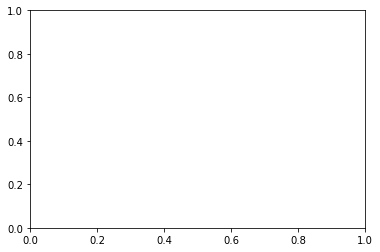

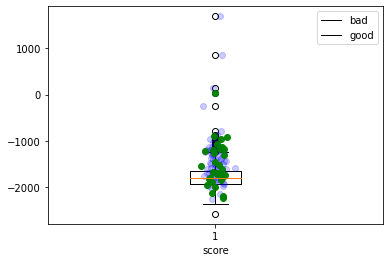

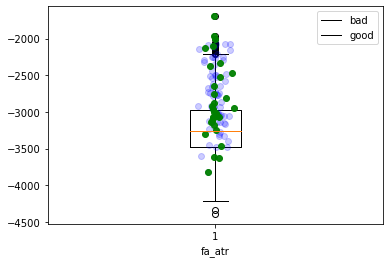

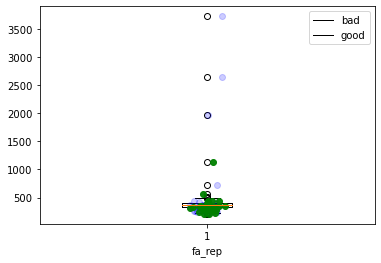

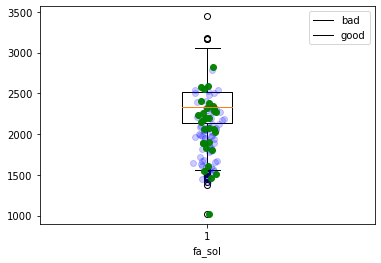

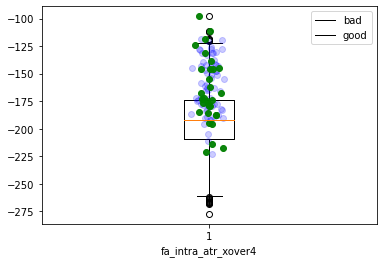

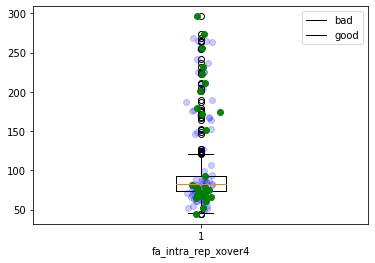

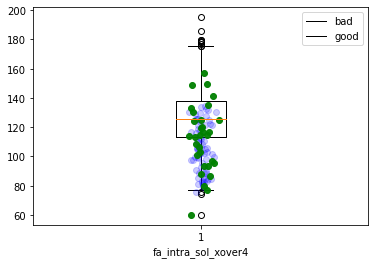

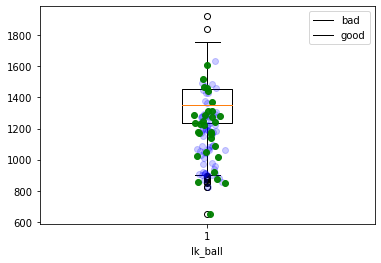

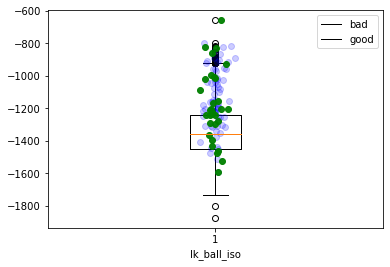

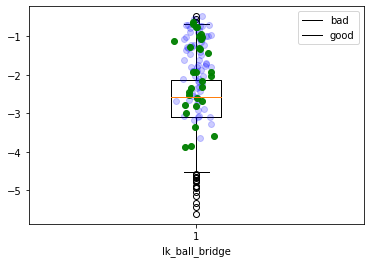

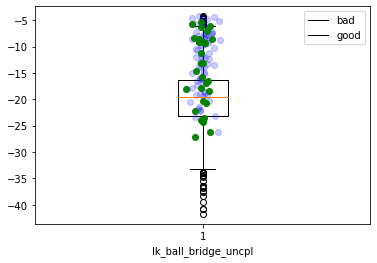

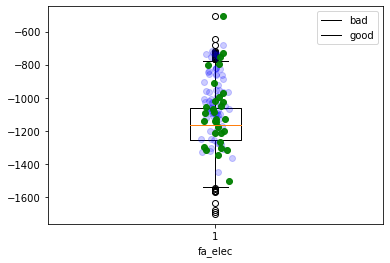

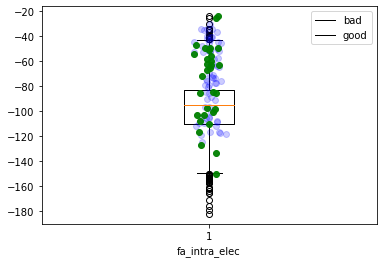

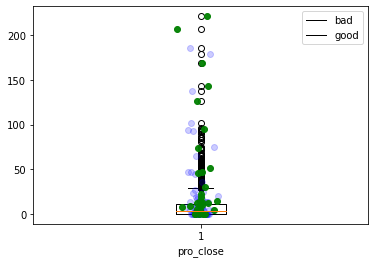

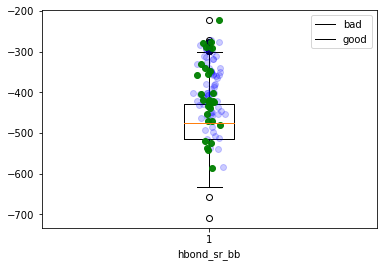

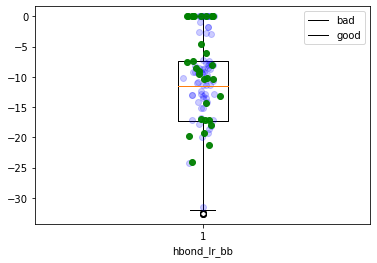

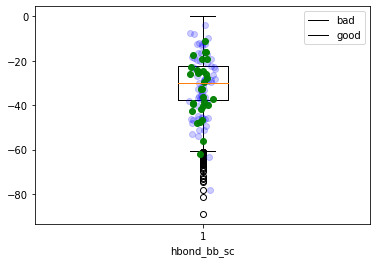

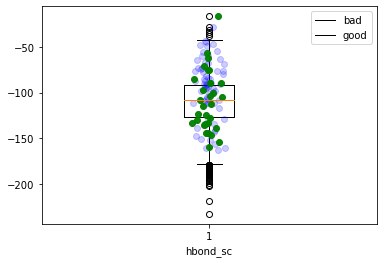

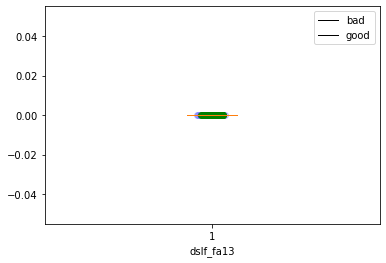

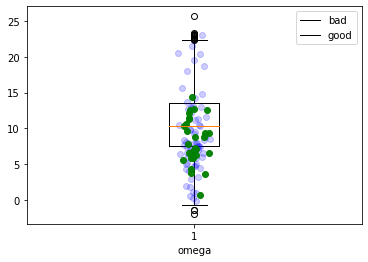

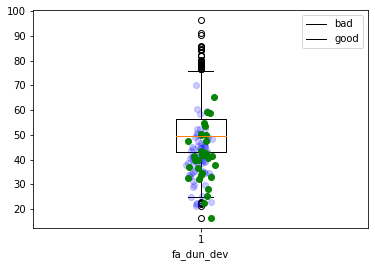

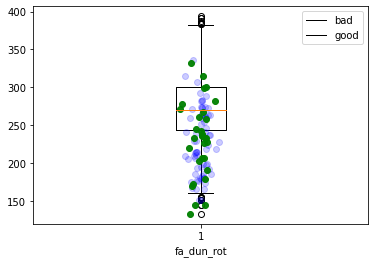

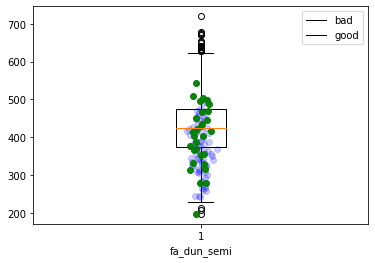

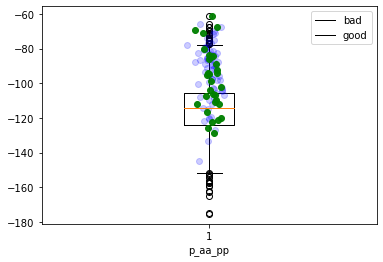

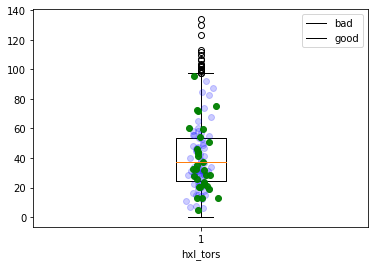

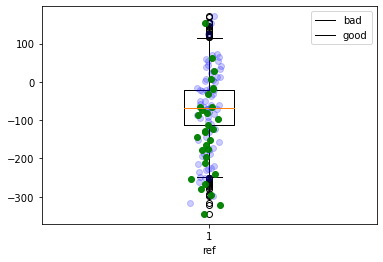

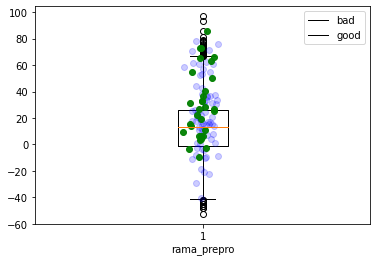

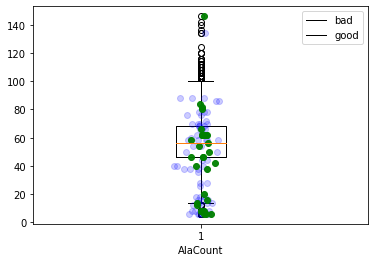

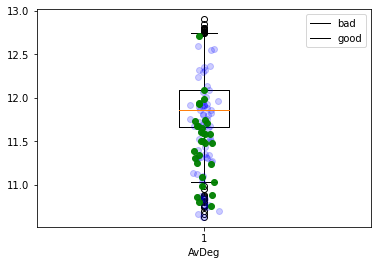

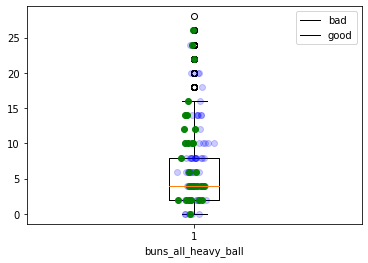

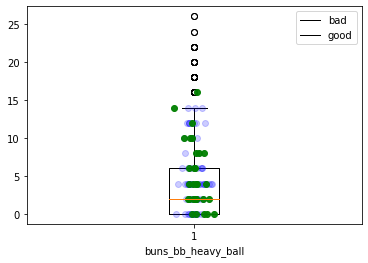

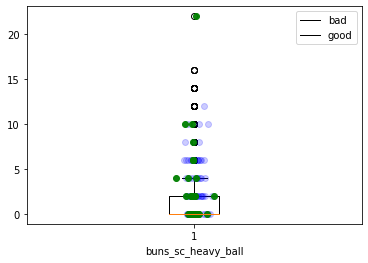

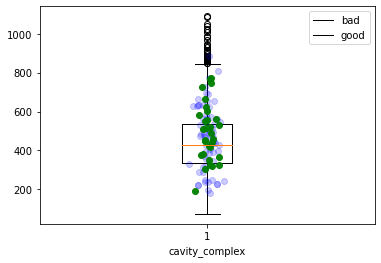

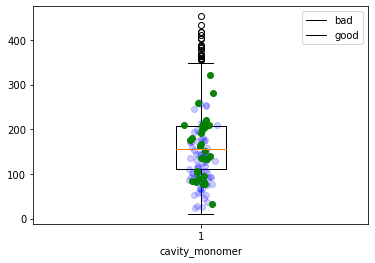

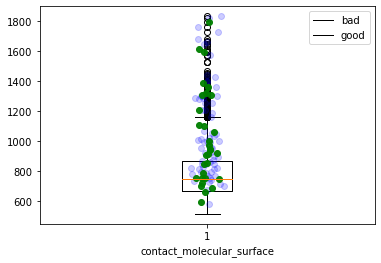

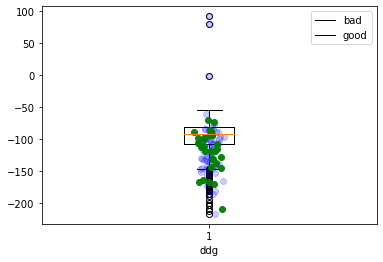

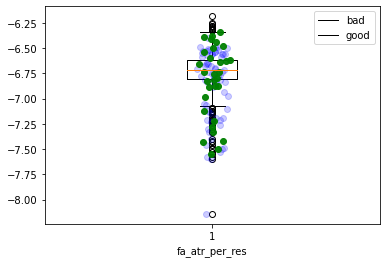

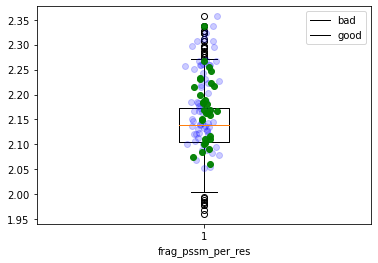

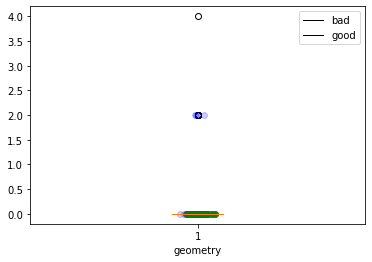

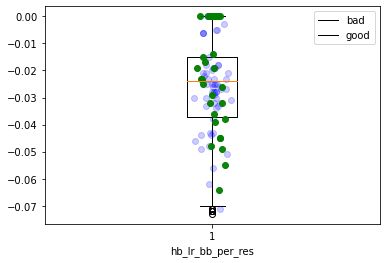

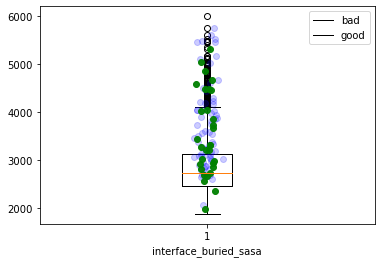

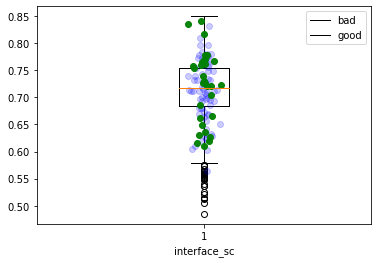

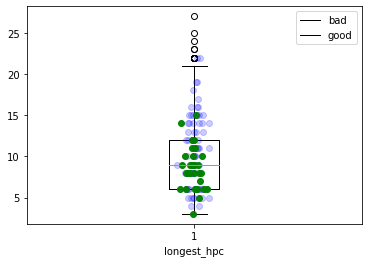

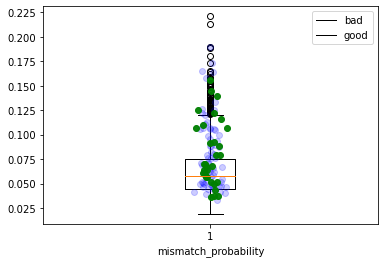

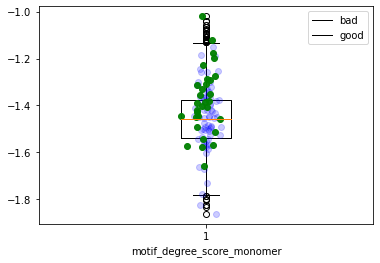

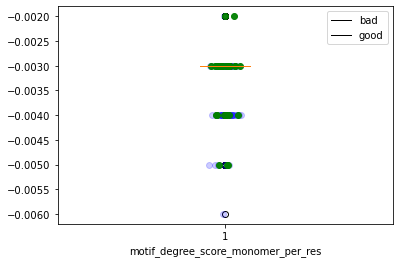

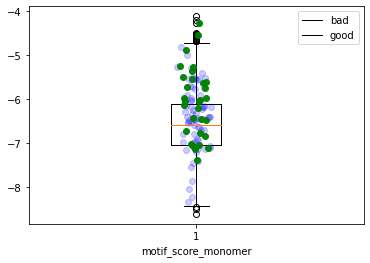

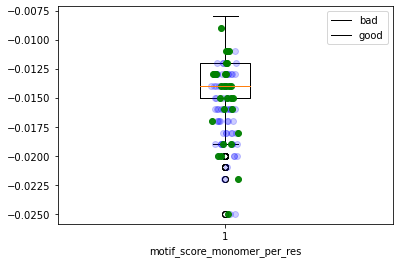

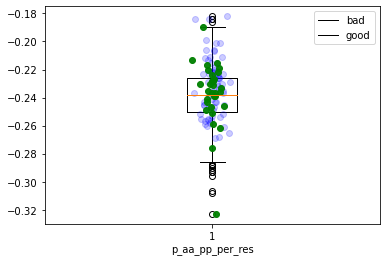

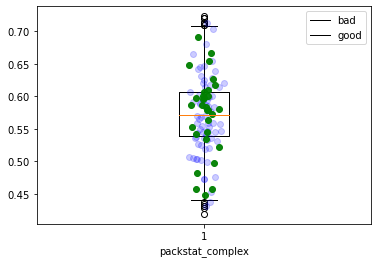

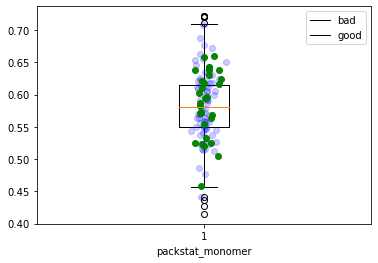

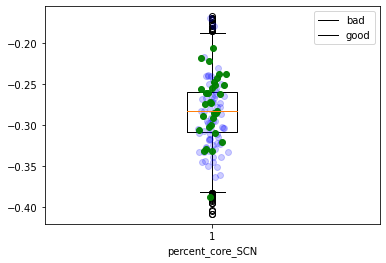

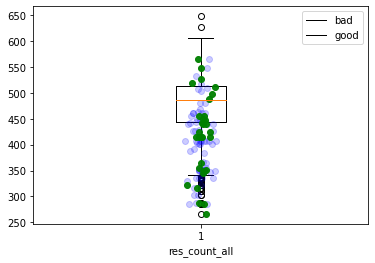

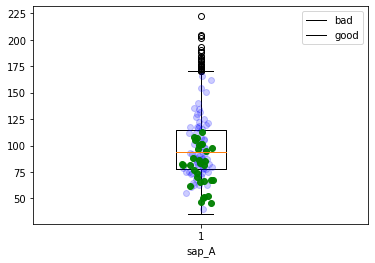

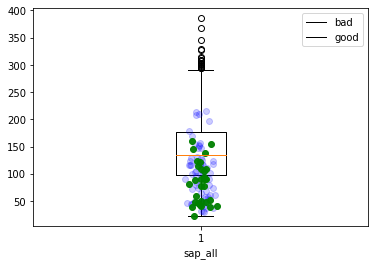

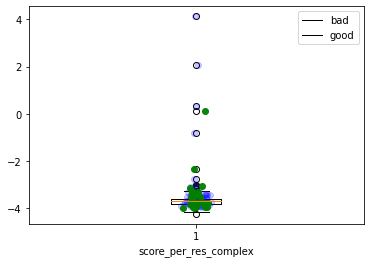

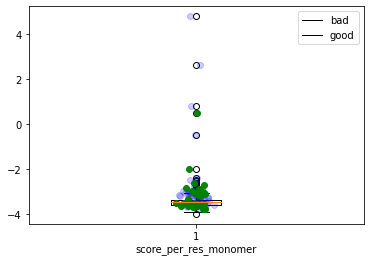

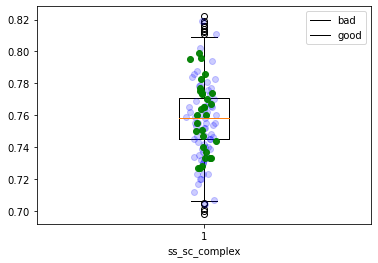

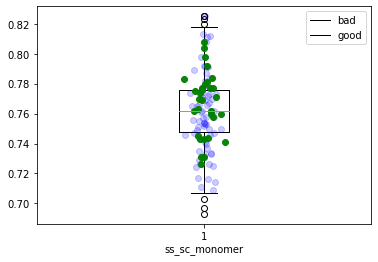

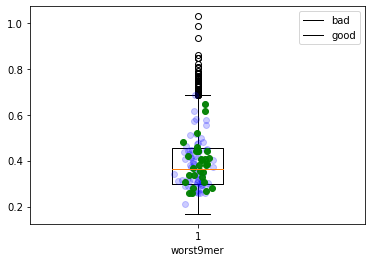

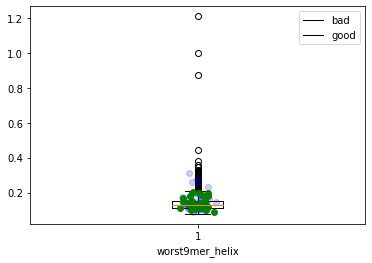

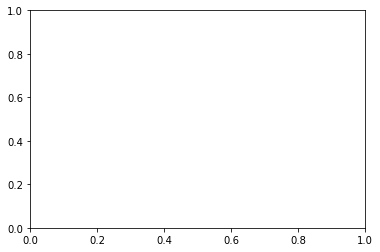

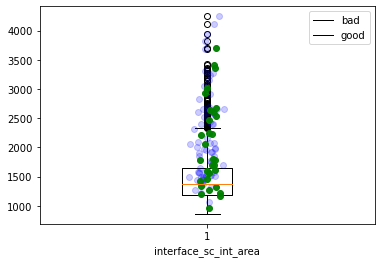

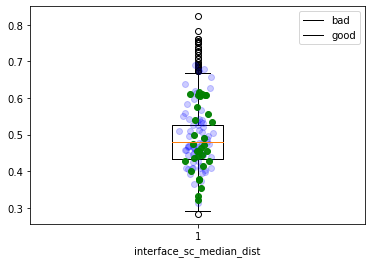

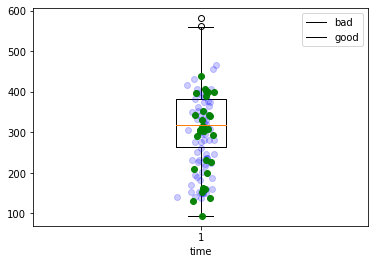

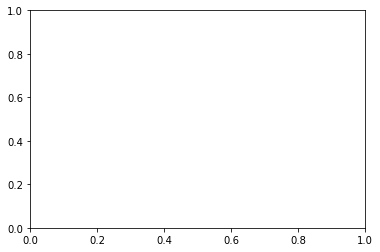

In [31]:
for term in df:
    try:
        plt.figure()
    
        bp = plt.boxplot(df[term])
        plt.xlabel(term)

        y1 = df_bad[term].values
        x1 = np.random.normal(1, 0.02, size=len(y1))

        y2 = df_good[term].values
        x2 = np.random.normal(1, 0.02, size=len(y2))

        plt1, = plt.plot(x1, y1, 'b.', alpha=0.2, marker='o', label='bad')
        plt2, = plt.plot(x2, y2, 'g.', alpha=0.95, marker='o', label='good')

        plt.legend(["bad", "good"])    
        plt.legend(handler_map={plt1: HandlerLine2D(numpoints=1), plt2: HandlerLine2D(numpoints=1)})
        plt.tight_layout()
        #plt.savefig(f"/home/drhicks1/donut_protein_manuscript/figs/{term}.png", dpi=400)
        #plt.yscale("log")
        #plt.savefig(f"/home/drhicks1/donut_protein_manuscript/figs/{term}_log.png", dpi=400)
        plt.show()
    except:
        continue

In [15]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


def bootstrap_auc(clf, X_train, y_train, X_test, y_test, nsamples=100):
    auc_values = []
    for b in range(nsamples):
        idx = np.random.randint(X_train.shape[0], size=X_train.shape[0])
        clf.fit(X_train[idx], y_train[idx])
        pred = clf.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test.ravel(), pred.ravel())
        auc_values.append(roc_auc)
    return np.percentile(auc_values, (2.5, 97.5))

def permutation_test(clf, X_train, y_train, X_test, y_test, nsamples=100):
    idx1 = np.arange(X_train.shape[0])
    idx2 = np.arange(X_test.shape[0])
    auc_values = np.empty(nsamples)
    for b in range(nsamples):
        np.random.shuffle(idx1)  # Shuffles in-place
        np.random.shuffle(idx2)
        clf.fit(X_train, y_train[idx1])
        pred = clf.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test[idx2].ravel(), pred.ravel())
        auc_values[b] = roc_auc
    clf.fit(X_train, y_train)
    pred = clf.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test.ravel(), pred.ravel())
    return np.mean(auc_values >= roc_auc)

def plot_roc(X, y, term, size, plot_i, fig):
    # split into train/test sets
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(testy))]
    # fit a model
    model = LogisticRegression(solver='lbfgs')
    
    pvalue = permutation_test(model, trainX, trainy, testX, testy)
    
    model.fit(trainX, trainy)
    # predict probabilities
    lr_probs = model.predict_proba(testX)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    # summarize scores
#     print('No Skill: ROC AUC=%.3f' % (ns_auc))
#     print('Logistic: ROC AUC=%.3f' % (lr_auc))
#     print(f"p-value: {round(pvalue, 3)}")
#     # calculate roc curve1
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
    
    
    # plot the roc curve for the model
    ax = fig.add_subplot(size, size, plot_i)
    ax.plot(ns_fpr, ns_tpr, linestyle='--')
    ax.plot(lr_fpr, lr_tpr, marker='.')
    # axis labels
    #ax.xlabel('False Positive Rate')
    #ax.ylabel('True Positive Rate')
    ax.title.set_text(f"{term}\nROC AUC: {round(lr_auc, 3)}\np-value: {round(pvalue, 3)}")
    # show the legend
    #ax.legend()
    #pyplot.tight_layout()
    # show the plot
    #pyplot.show()
    
def rank_terms(X, y, term):
    # split into train/test sets
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(testy))]
    # fit a model
    model = LogisticRegression(solver='lbfgs')
        
    model.fit(trainX, trainy)
    # predict probabilities
    lr_probs = model.predict_proba(testX)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    # summarize scores
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
    
    return [term, lr_auc]

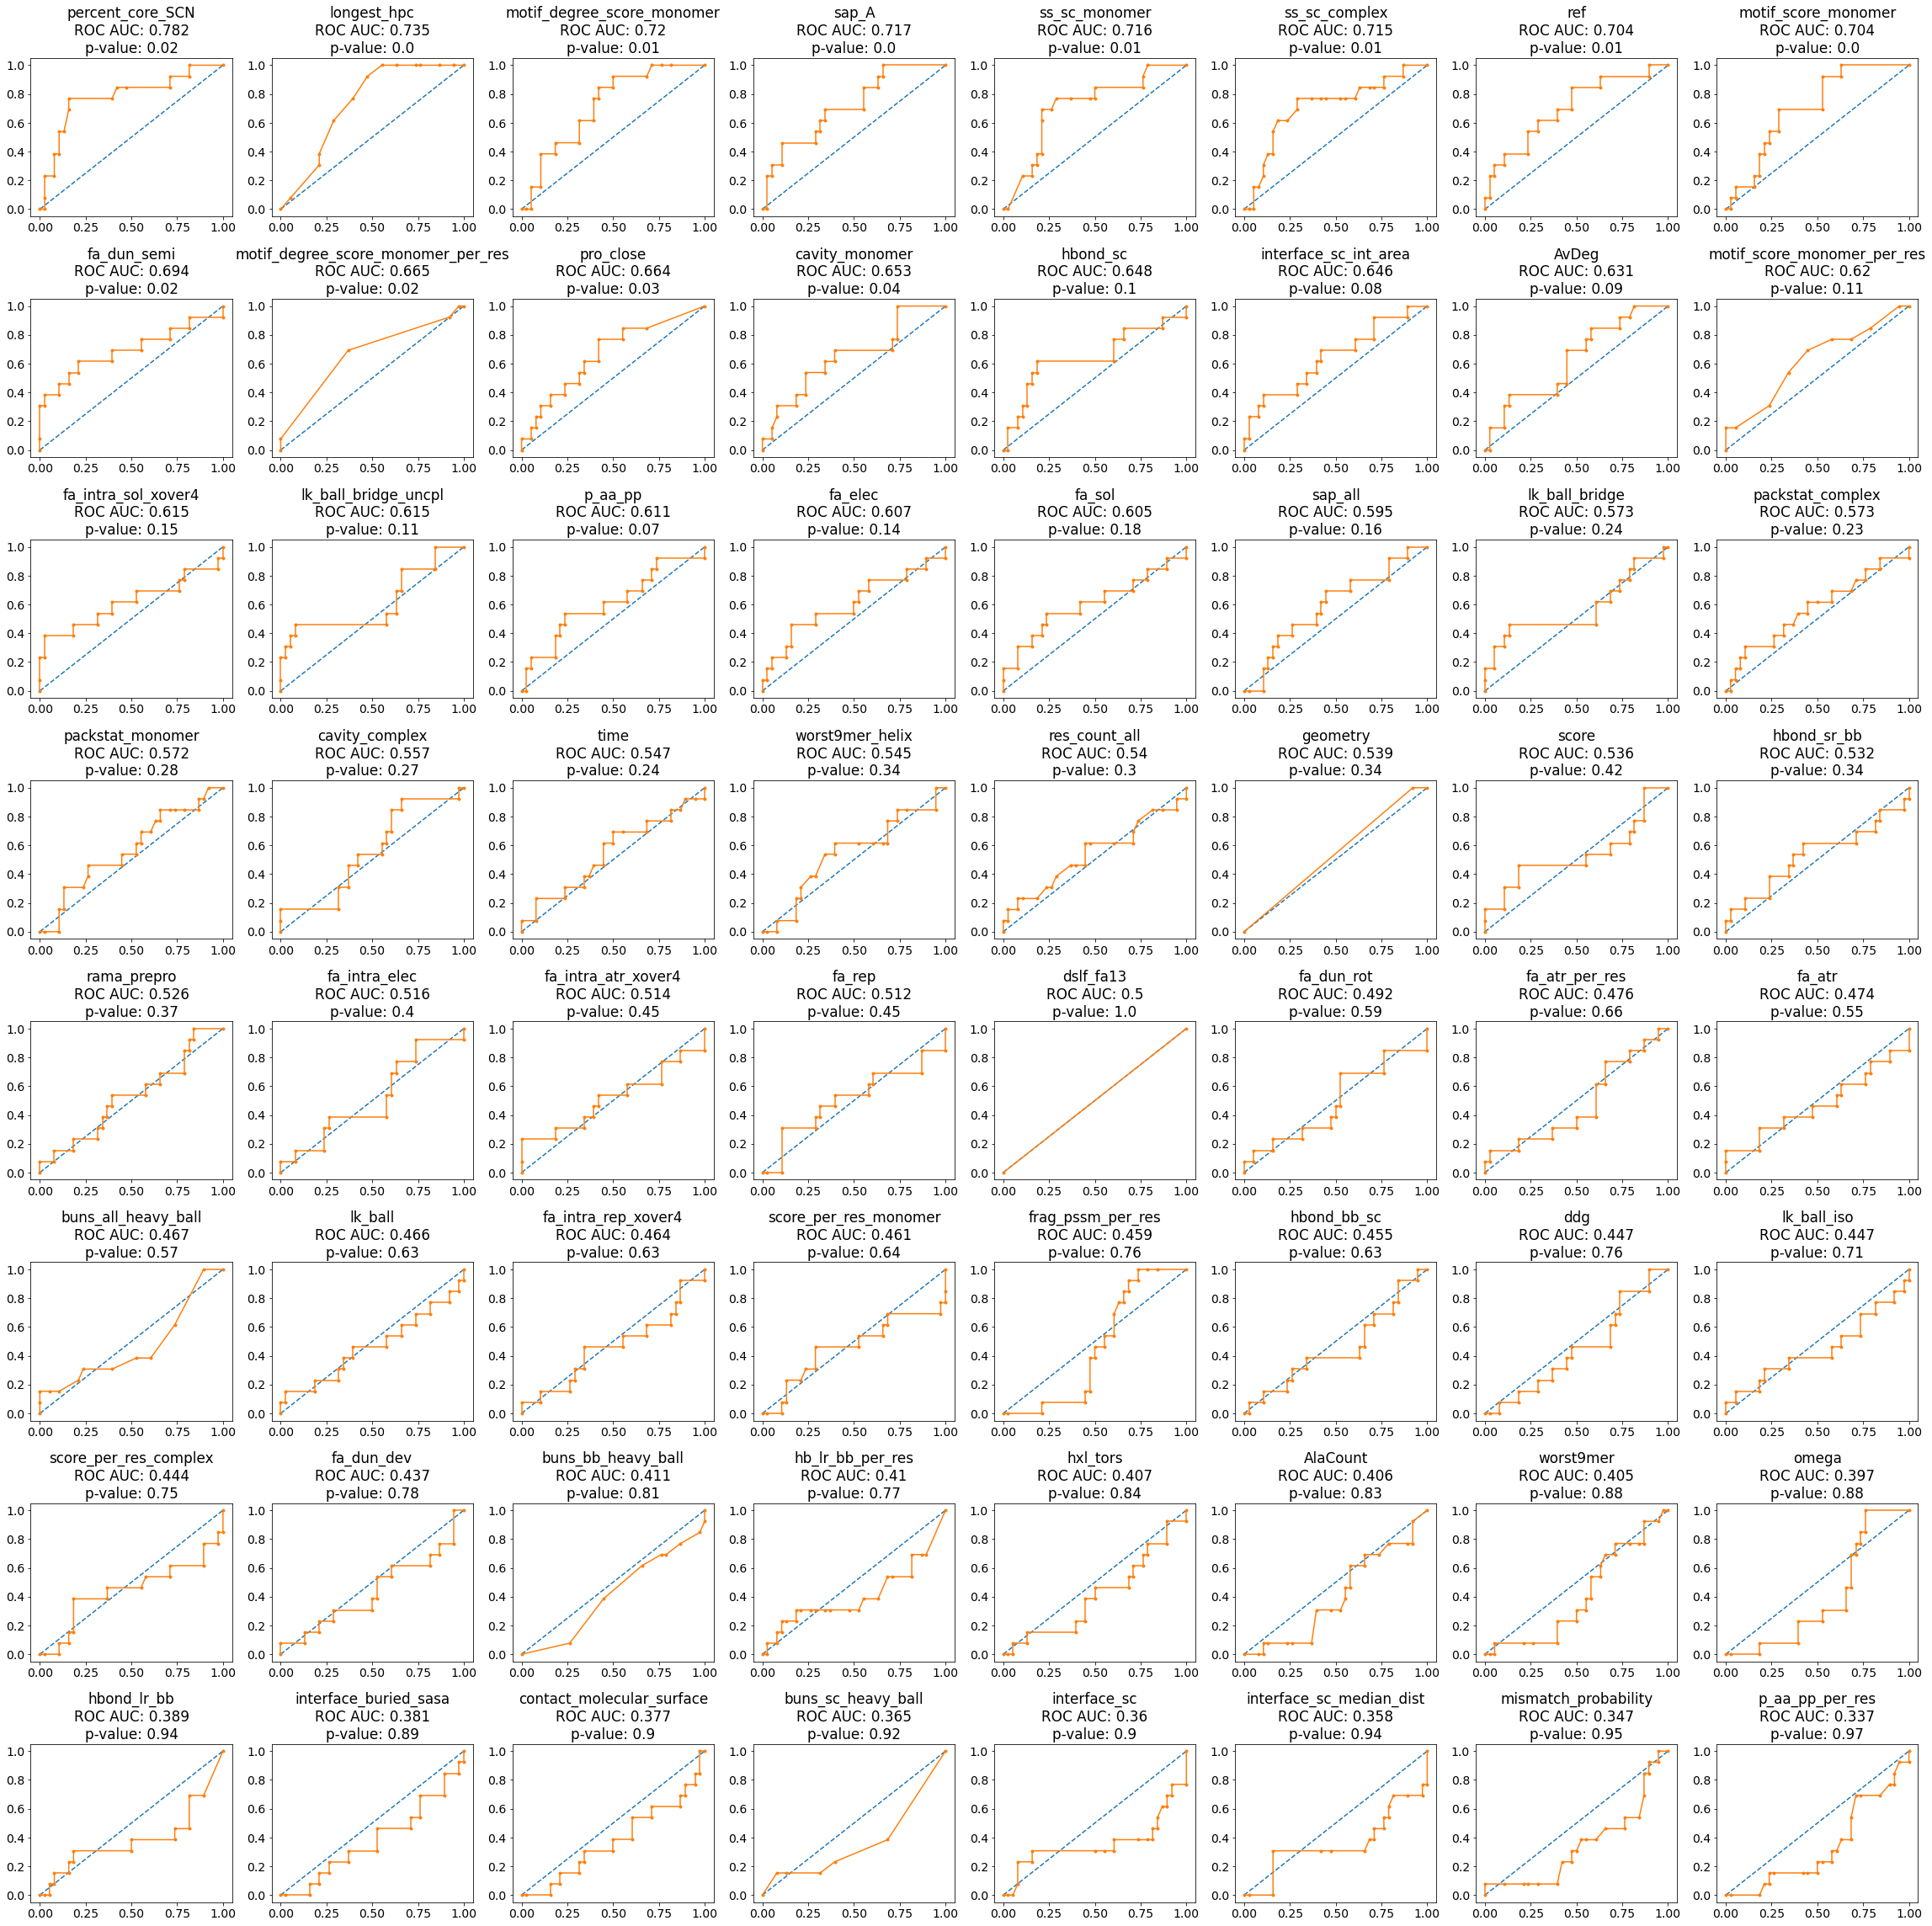

In [27]:
terms = ['score', 'fa_atr', 'fa_rep', 'fa_sol',
        'fa_intra_atr_xover4', 'fa_intra_rep_xover4',
        'fa_intra_sol_xover4', 'lk_ball', 'lk_ball_iso', 'lk_ball_bridge',
        'lk_ball_bridge_uncpl', 'fa_elec', 'fa_intra_elec', 'pro_close',
        'hbond_sr_bb', 'hbond_lr_bb', 'hbond_bb_sc', 'hbond_sc',
        'dslf_fa13', 'omega', 'fa_dun_dev', 'fa_dun_rot', 'fa_dun_semi',
        'p_aa_pp', 'hxl_tors', 'ref', 'rama_prepro', 'AlaCount', 'AvDeg',
        'buns_all_heavy_ball', 'buns_bb_heavy_ball', 'buns_sc_heavy_ball',
        'cavity_complex', 'cavity_monomer', 'contact_molecular_surface',
        'ddg', 'fa_atr_per_res', 'frag_pssm_per_res', 'geometry',
        'hb_lr_bb_per_res', 'interface_buried_sasa', 'interface_sc',
        'longest_hpc', 'mismatch_probability',
        'motif_degree_score_monomer', 'motif_degree_score_monomer_per_res',
        'motif_score_monomer', 'motif_score_monomer_per_res',
        'p_aa_pp_per_res', 'packstat_complex', 'packstat_monomer',
        'percent_core_SCN', 'res_count_all', 'sap_A', 'sap_all',
        'score_per_res_complex', 'score_per_res_monomer', 'ss_sc_complex',
        'ss_sc_monomer', 'worst9mer', 'worst9mer_helix',
        'interface_sc_int_area', 'interface_sc_median_dist', 'time']

ranks = []


ranks.sort(key=lambda x:x[1])
for i in range(len(terms)):
    term = terms[i]
    xs = df_good_bad[term].values
    xs = xs.reshape(-1, 1)
    ys = df_good_bad["success"].values
    ranks.append(rank_terms(xs, ys, term))
    
ranks.sort(key=lambda x:x[1], reverse=True)

terms = ranks

size = int(len(terms)**0.5)
fig = plt.figure(figsize=(size*4, size*4))
for i in range(len(terms)):
    term = terms[i][0]
    xs = df_good_bad[term].values
    xs = xs.reshape(-1, 1)
    ys = df_good_bad["success"].values
    plot_roc(xs, ys, term, size, i+1, fig)

plt.tight_layout()
plt.savefig("/home/drhicks1/donut_protein_manuscript/figs/metrics.png", dpi=300)
plt.show()

In [13]:
df1 = pd.read_csv("/home/drhicks1/donut_protein_manuscript/alphafold_characterized_only/alphafold_summary.csv")

df2 = pd.read_csv("/home/drhicks1/donut_protein_manuscript/alphafold_characterized_only/success.table", sep="\s+")

In [14]:
df = df1.merge(df2, on="description")

In [17]:
df.columns.values

array(['description', 'ptms', 'plddts', 'rmsds', 'max_ptm', 'max_plddt',
       'min_rmsd', 'max_ptm_rmsd', 'max_plddt_rmsd', 'success'],
      dtype=object)

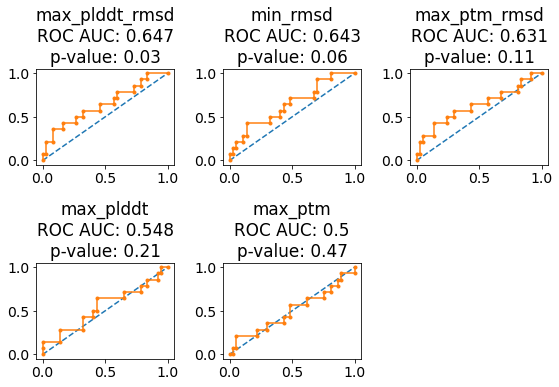

In [22]:
terms = ['max_ptm', 'max_plddt', 'min_rmsd', 'max_ptm_rmsd', 'max_plddt_rmsd']

ranks = []


ranks.sort(key=lambda x:x[1])
for i in range(len(terms)):
    term = terms[i]
    xs = df[term].values
    xs = xs.reshape(-1, 1)
    ys = df["success"].values
    ranks.append(rank_terms(xs, ys, term))
    
ranks.sort(key=lambda x:x[1], reverse=True)

terms = ranks

size = int(len(terms)**0.5)
fig = plt.figure(figsize=(size*4, size*4))
for i in range(len(terms)):
    term = terms[i][0]
    xs = df[term].values
    xs = xs.reshape(-1, 1)
    ys = df["success"].values
    plot_roc(xs, ys, term, size+1, i+1, fig)

plt.tight_layout()
plt.savefig("/home/drhicks1/donut_protein_manuscript/figs/af2_metrics.png", dpi=300)
plt.show()